# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [122]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [123]:
num_sample_per_class = 50000

In [124]:
try:
    # 1. Cargar el nuevo dataset multiclase
    data = pd.read_csv(f'Datasets/dataset_original.csv') 
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [125]:
try:
    data_gen = pd.read_csv(f'Datasets\dataset_Gen.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [126]:
data.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [127]:

data_gen.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,40.689346,0,0,No Info,38.338242,5.256777,235,1
1,0,76.082352,1,0,current,32.782810,6.864460,158,1
2,1,23.266781,0,0,current,31.726681,3.616340,86,0
3,1,43.222412,0,0,No Info,32.392994,5.474286,262,1
4,1,39.962341,0,0,No Info,37.148998,5.731811,277,1


In [128]:
# Convertir variables categóricas a numéricas
data['gender'] = data['gender'].astype(str).str.strip().str.upper()
data['gender'] = data['gender'].map({'FEMALE': 0, 'MALE': 1, 'OTHER': 2})
smoking_mapping = {'never': 0, 'No Info':1, 'current': 2, 'ever': 3, 'former':4, 'not current': 5}
data['smoking_history'] = data['smoking_history'].map(smoking_mapping)
data_gen['smoking_history'] = data_gen['smoking_history'].map(smoking_mapping)

data_sample = data

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
print("Preprocesamiento listo. Nuevas columnas:")
print(data_gen.columns)
data.head()

Preprocesamiento listo. Nuevas columnas:
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')
Preprocesamiento listo. Nuevas columnas:
Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0


In [129]:
data.info()
data_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  int64  
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 6.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age          

In [130]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [131]:
#Resample, solo necesario para dataset original ya que generado ya esta balanceado
data_count = data['diabetes'].value_counts() #num_sample_per_class
min_dc = data_count.min()
max_dc = data_count.max()
if data_count[0] > min_dc:
    if max_dc > num_sample_per_class:
        class_0 = data[data['diabetes'] == 0].sample(n=num_sample_per_class, random_state=42) 
    else:
        class_0 = data[data['diabetes'] == 0].sample(n=max_dc, random_state=42) 
else:
    class_0 = data[data['diabetes'] == 0].sample(n=min_dc, random_state=42) 
if data_count[1] > min_dc:
    if max_dc > num_sample_per_class:
        class_1 = data[data['diabetes'] == 1].sample(n=num_sample_per_class, random_state=42) 
    else:
        class_1 = data[data['diabetes'] == 1].sample(n=max_dc, random_state=42) 
else:
    class_1 = data[data['diabetes'] == 1].sample(n=min_dc, random_state=42) 


balanced_train_data = pd.concat([class_0, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print("--- Distribución de clases en la muestra del 10% ---")
print(balanced_train_data['diabetes'].value_counts())
print("-" * 50)
data_sample = balanced_train_data

--- Distribución de clases en la muestra del 10% ---
diabetes
0    50000
1     8500
Name: count, dtype: int64
--------------------------------------------------


In [132]:
#Resample, solo necesario para dataset original ya que generado ya esta balanceado
data_count = data['diabetes'].value_counts() #num_sample_per_class
class_0_gen = pd.DataFrame(columns=data_gen.columns)
class_1_gen = pd.DataFrame(columns=data_gen.columns)
if ((0 in data_count) and (data_count[0]<num_sample_per_class)):
    class_0_gen = data_gen[data_gen['diabetes'] == 0].sample(n=num_sample_per_class-data_count[0], random_state=42)
if ((1 in data_count) and (data_count[1]<num_sample_per_class)):
    class_1_gen = data_gen[data_gen['diabetes'] == 1].sample(n=num_sample_per_class-data_count[1], random_state=42) 
if ((not class_0_gen.empty)and (not class_1_gen.empty)):
    balanced_train_data_gen = pd.concat([class_0_gen, class_1_gen]).sample(frac=1, random_state=42).reset_index(drop=True)
else: 
    balanced_train_data_gen = class_1_gen
print("--- Distribución de clases en la muestra del 10% ---")
print(balanced_train_data_gen['diabetes'].value_counts())
print("-" * 50)
data_gen_sample = balanced_train_data_gen

--- Distribución de clases en la muestra del 10% ---
diabetes
1    41500
Name: count, dtype: int64
--------------------------------------------------


In [133]:

# 1. (Opcional) Tomar una muestra del 10% para pruebas rápidas
# Esto mantiene la proporción original de clases en la muestra
#data_sample['diabetes'].value_counts() para cantidad minima escribir despues
#_, data_sample, _, _ = train_test_split(balanced_train_data, balanced_train_data['diabetes'], test_size=0.10, random_state=42, stratify=data['diabetes'])


# print("--- Distribución de clases en la muestra del 10% (antes de SMOTE) ---")
# print(data_sample['diabetes'].value_counts())
# print("-" * 50)

# 2. Separar características (x) y objetivo (y) de la muestra
x = data_sample.drop(columns=["diabetes"]).to_numpy()
y = data_sample["diabetes"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y) # 20% para test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train) # 15% del resto para validación

x_gen = data_gen_sample.drop(columns=["diabetes"]).to_numpy()
y_gen = data_gen_sample["diabetes"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(x_gen, y_gen, test_size=0.20, random_state=42, stratify=y_gen) # 20% para test
X_gen_train, X_gen_val, y_gen_train, y_gen_val = train_test_split(X_gen_train, y_gen_train, test_size=0.15, random_state=42, stratify=y_gen_train) # 15% del resto para validación

X_train_orig_pd = pd.DataFrame(X_train)
y_train_orig_pd = pd.Series(y_train)
X_test_orig_pd = pd.DataFrame(X_test)
y_test_orig_pd = pd.Series(y_test)
X_val_orig_pd = pd.DataFrame(X_val)
y_val_orig_pd = pd.Series(y_val)

X_gen_train_pd = pd.DataFrame(X_gen_train)
y_gen_train_pd = pd.Series(y_gen_train)
X_gen_test_pd = pd.DataFrame(X_gen_test)
y_gen_test_pd = pd.Series(y_gen_test)
X_gen_val_pd = pd.DataFrame(X_gen_val)
y_gen_val_pd = pd.Series(y_gen_val)

X_train = (pd.concat([X_gen_train_pd, X_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_train = (pd.concat([y_gen_train_pd, y_train_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

X_test = (pd.concat([X_gen_test_pd, X_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_test = (pd.concat([y_gen_test_pd, y_test_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

X_val = (pd.concat([X_gen_val_pd, X_val_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()
y_val = (pd.concat([y_gen_val_pd, y_val_orig_pd]).sample(frac=1, random_state=42).reset_index(drop=True)).to_numpy()

# 4. Aplicar el escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Usar el mismo scaler del train
X_test = scaler.transform(X_test) # Usar el mismo scaler del train



In [134]:
#Formato correcto
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [135]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [136]:
len(train_data)

68000

In [137]:
#Definir un modelo para trabajar

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(x.shape[1], 256) # Ajuste automático al número de columnas
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 2)
        self.act = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [138]:
testeo = MLP()
# lr = 1e-4
# opt = torch.optim.SGD(testeo.parameters(), lr=lr, weight_decay=1e-4)
lr = 1e-4
opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()


In [139]:
testeo_path = f'Guardar_modelo/MLP/Binary/Binary_{num_sample_per_class}_pytorch.pth'
testeo_path_FULL = f'Guardar_modelo/MLP/Binary/Binary_{num_sample_per_class}_pytorch_FULL.pth'

In [140]:
#Cargar Pesos
#testeo.load_state_dict(torch.load(testeo_path))
#Cargar Modelo
#testeo = torch.load(testeo_path_FULL)

In [141]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [142]:
#Entrenamiento

n_epochs = 2000
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 106


In [143]:
#Guardar Pesos
torch.save(testeo.state_dict(), testeo_path)
#Guardar Modelo Completo
torch.save(testeo, testeo_path_FULL)

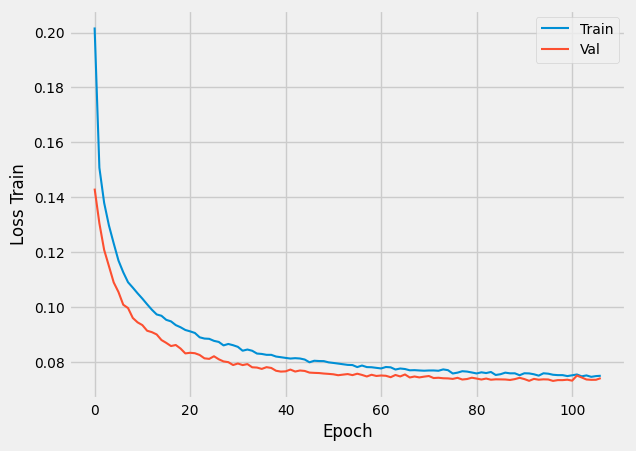

In [144]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [145]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')
print(classification_report(y_test, y_hat))

Training Accuracy: 0.97
Testing Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10000
           1       0.99      0.95      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



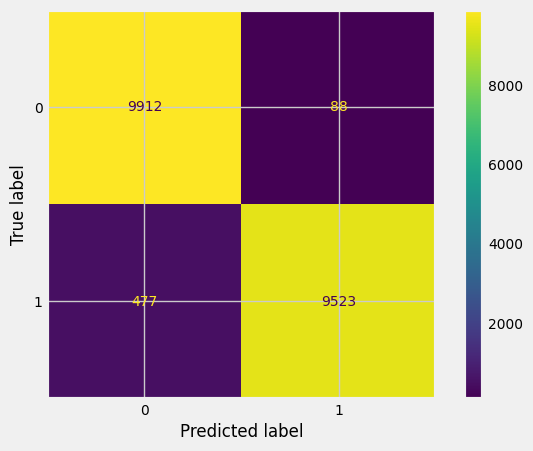

In [146]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()